In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/home-credit-default-risk')

app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

In [2]:
# 결측치 확인 -> 하지만 LightGBM은 내부적으로 결측치를 알아서 처리하므로 따로 처리 X
app_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [57]:
# 종속변수(TARGET)의 분포도 확인
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [58]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
columns = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
           'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 
           'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
           'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [10]:
# Target 값에 따른 수치형 feature들의 분포도 시각화 함수 정의
def numeric_target_plot(df, columns):
    cond0 = (df[df['TARGET'] == 0])
    cond1 = (df[df['TARGET'] == 1])
    
    for column in columns:
        print(f"Column name: {column}")
        fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2,
                                squeeze=False)
        # sns.violinplot(x='TARGET', y=column, data=df, ax=axes[0][0])
        sns.distplot(df[cond0][column], label='0', color='blue',
                    ax=axes[0][1])
        sns.distplot(df[cond1][column], label='1', color='red',
                    ax=axes[0][1])
        plt.show()

In [ ]:
numeric_target_plot(app_train, columns)

In [20]:
# Category feature들만 추출해서 TARGET값에 따라 시각화
cat_cols = app_train.dtypes[app_train.dtypes == 'object'].index.tolist()
print(cat_cols)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [42]:
# Category feature 시각화하는 함수 정의
def category_plot(df, columns):
    for column in columns:
        plot = sns.catplot(x=column, col='TARGET', kind='count',
                   data=df).set_titles(f"Column:{column}")
        plot.set_xticklabels(rotation=60)
        plt.show()

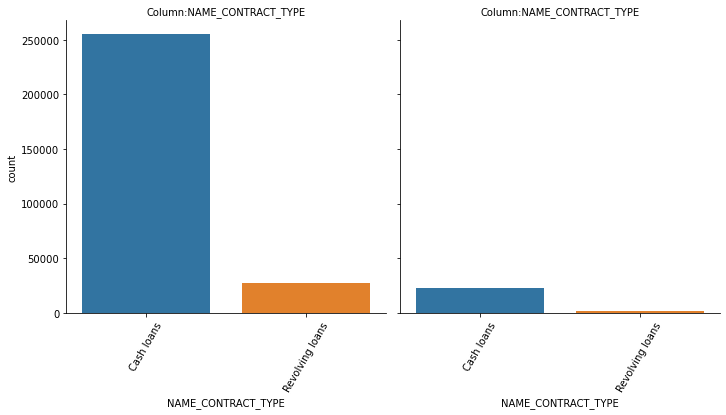

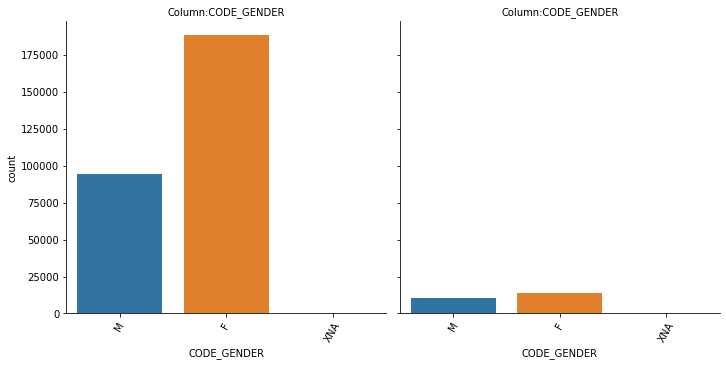

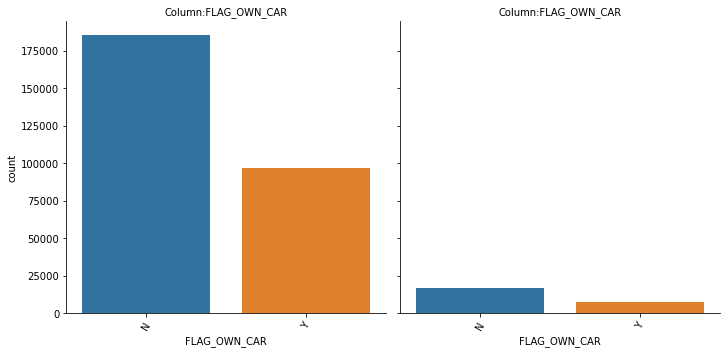

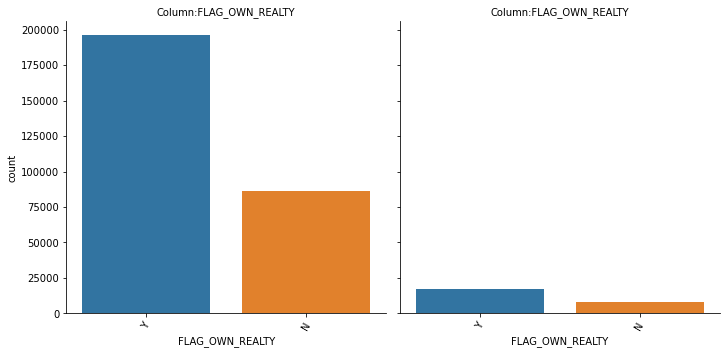

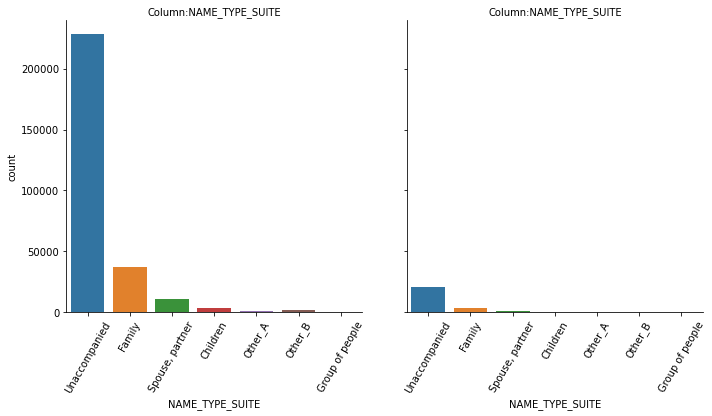

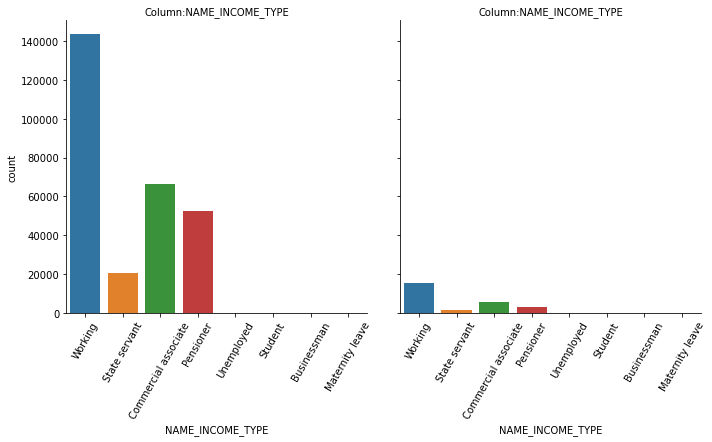

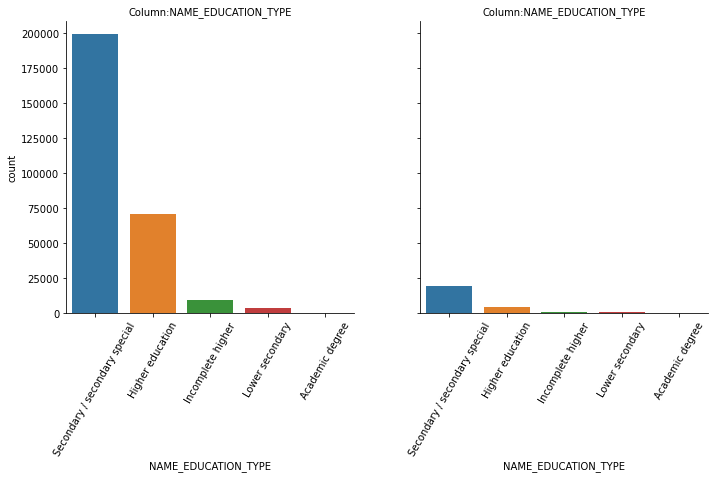

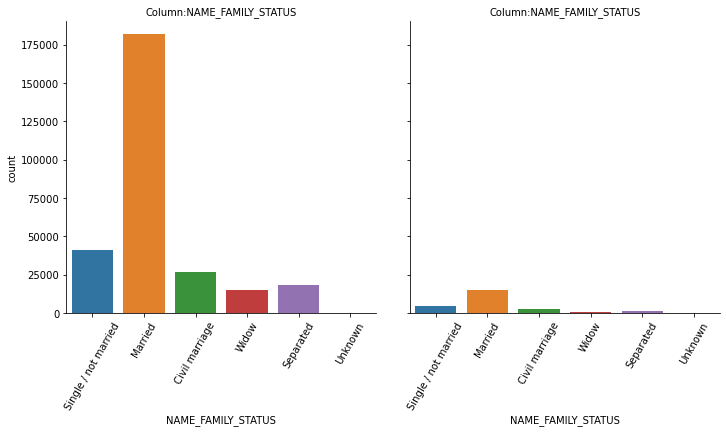

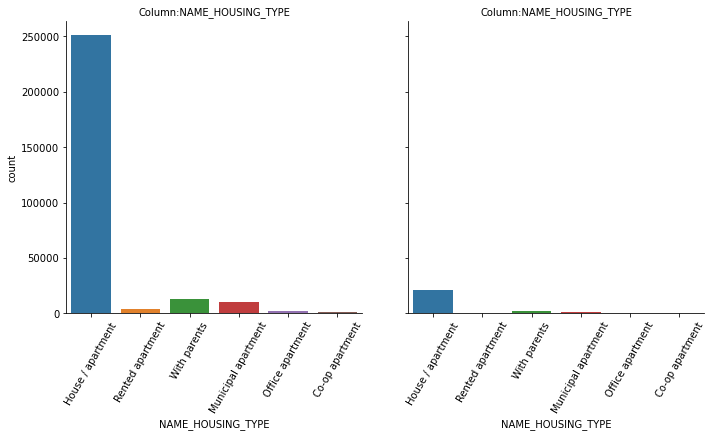

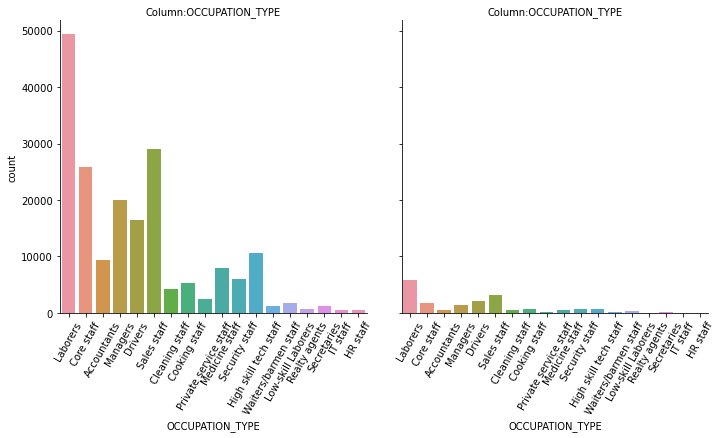

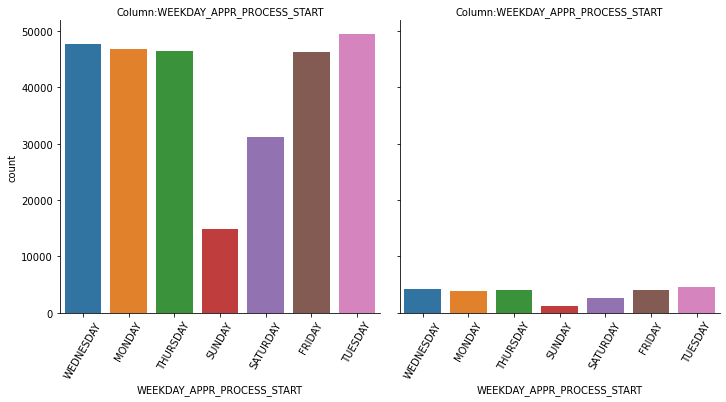

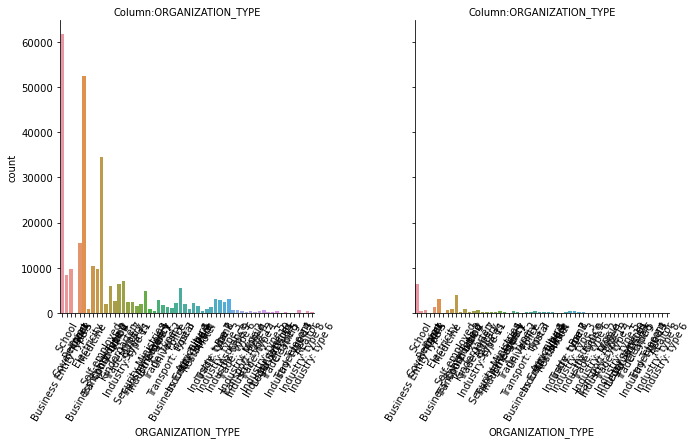

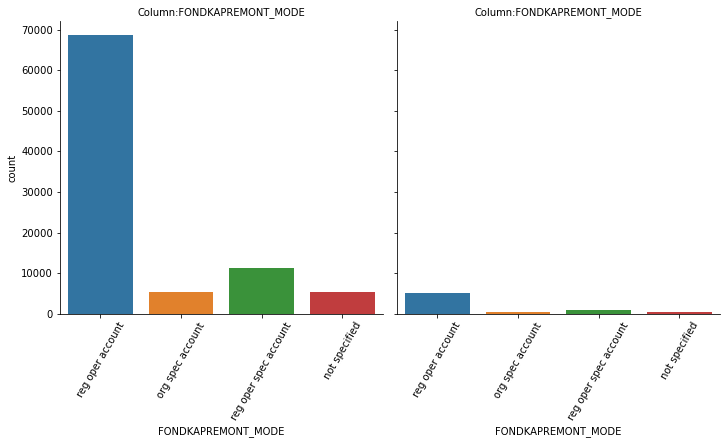

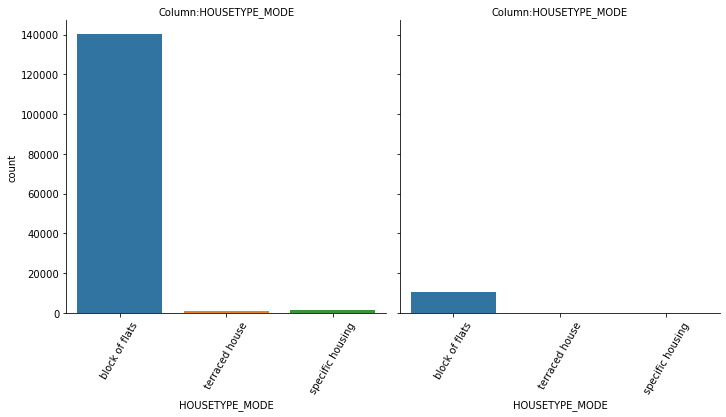

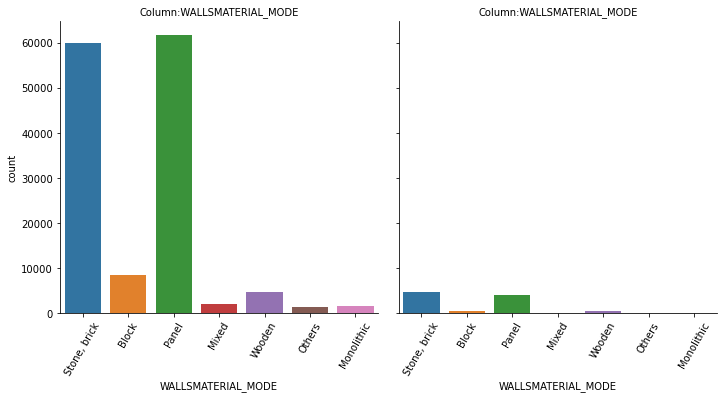

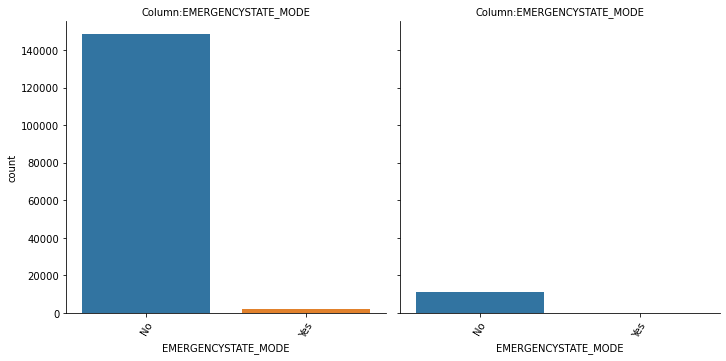

In [43]:
category_plot(app_train, cat_cols)

In [ ]:
# 대출횟수 대비 연체 비율
cond_0 = (app_train[app_train['TARGET'] ==0])
cond_1 = (app_train[app_train['TARGET'] ==1])
cond_m = (app_train[app_train['CODE_GENDER'] == 'M'])
cond_f = (app_train[app_train['CODE_GENDER'] == 'F'])

# 전체 건수 대비 남성과 여성의 비율 확인
print(app_train['CODE_GENDER'].value_counts()/app_train.shape[0])
# TARGET=1 일 경우 남성과 여성의 비율 확인
print(app_train[cond_1]['CODE_GENDER'].value_counts()/app_train[cond_1].shape[0])
# TARGET=0 일 경우 남성과 여성의 비율 확인
print(app_train[cond_0]['CODE_GENDER'].value_counts()/app_train[cond_0].shape[0])

---

# 주요 Featuree들에 대한 피처 엔지니어링 수행

- baseline 모델의 피처 중요도에서 가장 높았던 변수들을 중심으로 파생변수 생성

In [64]:
series = pd.Series(app_train.columns)
series[series.str.contains('EXT')]

41    EXT_SOURCE_1
42    EXT_SOURCE_2
43    EXT_SOURCE_3
dtype: object

In [65]:
app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [66]:
# 결측치까지 포함해서 개수 세기
app_train['EXT_SOURCE_1'].value_counts(dropna=False)

NaN         173378
0.546426         5
0.598469         5
0.499002         5
0.605152         5
             ...  
0.381263         1
0.259241         1
0.116346         1
0.171978         1
0.844540         1
Name: EXT_SOURCE_1, Length: 114585, dtype: int64

In [67]:
app_train['EXT_SOURCE_2'].value_counts(dropna=False)

0.285898    721
NaN         660
0.262258    417
0.265256    343
0.159679    322
           ... 
0.383020      1
0.786006      1
0.256132      1
0.297243      1
0.336367      1
Name: EXT_SOURCE_2, Length: 119832, dtype: int64

In [68]:
app_train['EXT_SOURCE_3'].value_counts(dropna=False)

NaN         60965
0.746300     1460
0.713631     1315
0.694093     1276
0.670652     1191
            ...  
0.887664        1
0.879506        1
0.020311        1
0.849170        1
0.014556        1
Name: EXT_SOURCE_3, Length: 815, dtype: int64

In [69]:
# EXT_SOURCE 변수 3개를 모두 이용해 row level로 평균, 표준편차값 추출
# default, axis=0인 mean()을 취해주면 column-level로의 평균값이 도출됨
# row-level로 EXT_SOURCE_1,2,3을 합한 평균, 표준편차값을 계산하려면 axis=1로 설정해주기!
print(app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1))


0         0.161787
1         0.466757
2         0.642739
3         0.650442
4         0.322738
            ...   
307506    0.413601
307507    0.115992
307508    0.499536
307509    0.587593
307510    0.518984
Length: 307511, dtype: float64


In [3]:
# 이상치 제거
# LightGBM은 NULL값을 트리 모델 생성하는데 사용할 수 있으므로 일괄적으로 Null로 변환 
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)
app_train['DAYS_EMPLOYED'].value_counts(dropna=False)

 NaN        55374
-200.0        156
-224.0        152
-199.0        151
-230.0        151
            ...  
-8868.0         1
-13006.0        1
-10261.0        1
-14079.0        1
-9062.0         1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [4]:
# Feature engineering 해주기 위해 우선 train, test 데이터 결합
apps = pd.concat([app_train, app_test], axis=0)
apps.shape

(356255, 122)

In [5]:
apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

In [6]:
apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','APPS_EXT_SOURCE_STD']].head(10)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APPS_EXT_SOURCE_STD
0,0.083037,0.262949,0.139376,0.092026
1,0.311267,0.622246,NaN,0.219895
2,NaN,0.555912,0.729567,0.122792
3,NaN,0.650442,NaN,NaN
4,NaN,0.322738,NaN,NaN
5,NaN,0.354225,0.621226,0.188799
6,0.774761,0.724000,0.492060,0.150717
7,NaN,0.714279,0.540654,0.122771
8,0.587334,0.205747,0.751724,0.280096
9,NaN,0.746644,NaN,NaN


In [7]:
# 3개의 값중 하나만 있으면 표준편차를 파악할 수 없기 때문에 std결측치에 std의 평균값을 넣어주자
apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
apps['APPS_EXT_SOURCE_STD'].isnull().sum()

0

In [8]:
# AMT_CREDIT(대출 금액)으로 대출과 관련된 금액 추가 가공. 
apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']

In [9]:
# AMT_INCOME_TOTAL 비율로 대출 금액 관련 피처 가공
apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
# 가족수를 고려한 가처분 소득 피처 가공. 
apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']

In [10]:
# DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공. 
apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

In [11]:
# Categorical feature 레이블 인코딩 수행
object_cols = apps.dtypes[apps.dtypes == 'object'].index.tolist()
for col in object_cols:
    apps[col] = pd.factorize(apps[col])[0]

In [12]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 136 entries, SK_ID_CURR to APPS_CAR_EMPLOYED_RATIO
dtypes: float64(81), int64(55)
memory usage: 372.4 MB


In [13]:
# Train/ Test 재분리 - Target이 결측치인 값을 기준으로
app_train = apps[~apps['TARGET'].isnull()]
app_test = apps[apps['TARGET'].isnull()]

# Test데이터는 TARGET 값 drop
app_test = app_test.drop('TARGET', axis=1)
app_train.shape, app_test.shape

((307511, 136), (48744, 135))

In [14]:
# Train 데이터로 Train, Validation 데이터로 재분할
from sklearn.model_selection import train_test_split

ftr_train = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
tgt_train = app_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(ftr_train,
                                                 tgt_train,
                                                 test_size=0.3,
                                                 random_state=42)
X_train.shape, X_val.shape

((215257, 134), (92254, 134))

In [18]:
# LightGBM 모델링
from lightgbm import LGBMClassifier

rgb_clf = LGBMClassifier(n_estimators=500,
                        learning_rate=0.02,
                        num_leaves=32,
                        subsample=0.8,#과적합막기위해 데이터의 몇프로를 사용할지
                        max_depth=12,
                        silent=True,#run동안 메세지 출력 여부
                        verbose=-1,
                        n_jobs=-1)

rgb_clf.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_val, y_val)],
           early_stopping_rounds=100, verbose=100,#몇 step마다 metric출력시킬건지
            eval_metric='auc')
            

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.760348	training's binary_logloss: 0.247431	valid_1's auc: 0.748923	valid_1's binary_logloss: 0.249528
[200]	training's auc: 0.78074	training's binary_logloss: 0.240349	valid_1's auc: 0.759509	valid_1's binary_logloss: 0.245621
[300]	training's auc: 0.795163	training's binary_logloss: 0.235712	valid_1's auc: 0.763967	valid_1's binary_logloss: 0.244158
[400]	training's auc: 0.807483	training's binary_logloss: 0.231953	valid_1's auc: 0.765635	valid_1's binary_logloss: 0.24362
[500]	training's auc: 0.817878	training's binary_logloss: 0.228679	valid_1's auc: 0.766196	valid_1's binary_logloss: 0.243437
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.817878	training's binary_logloss: 0.228679	valid_1's auc: 0.766196	valid_1's binary_logloss: 0.243437


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=500,
               num_leaves=32, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

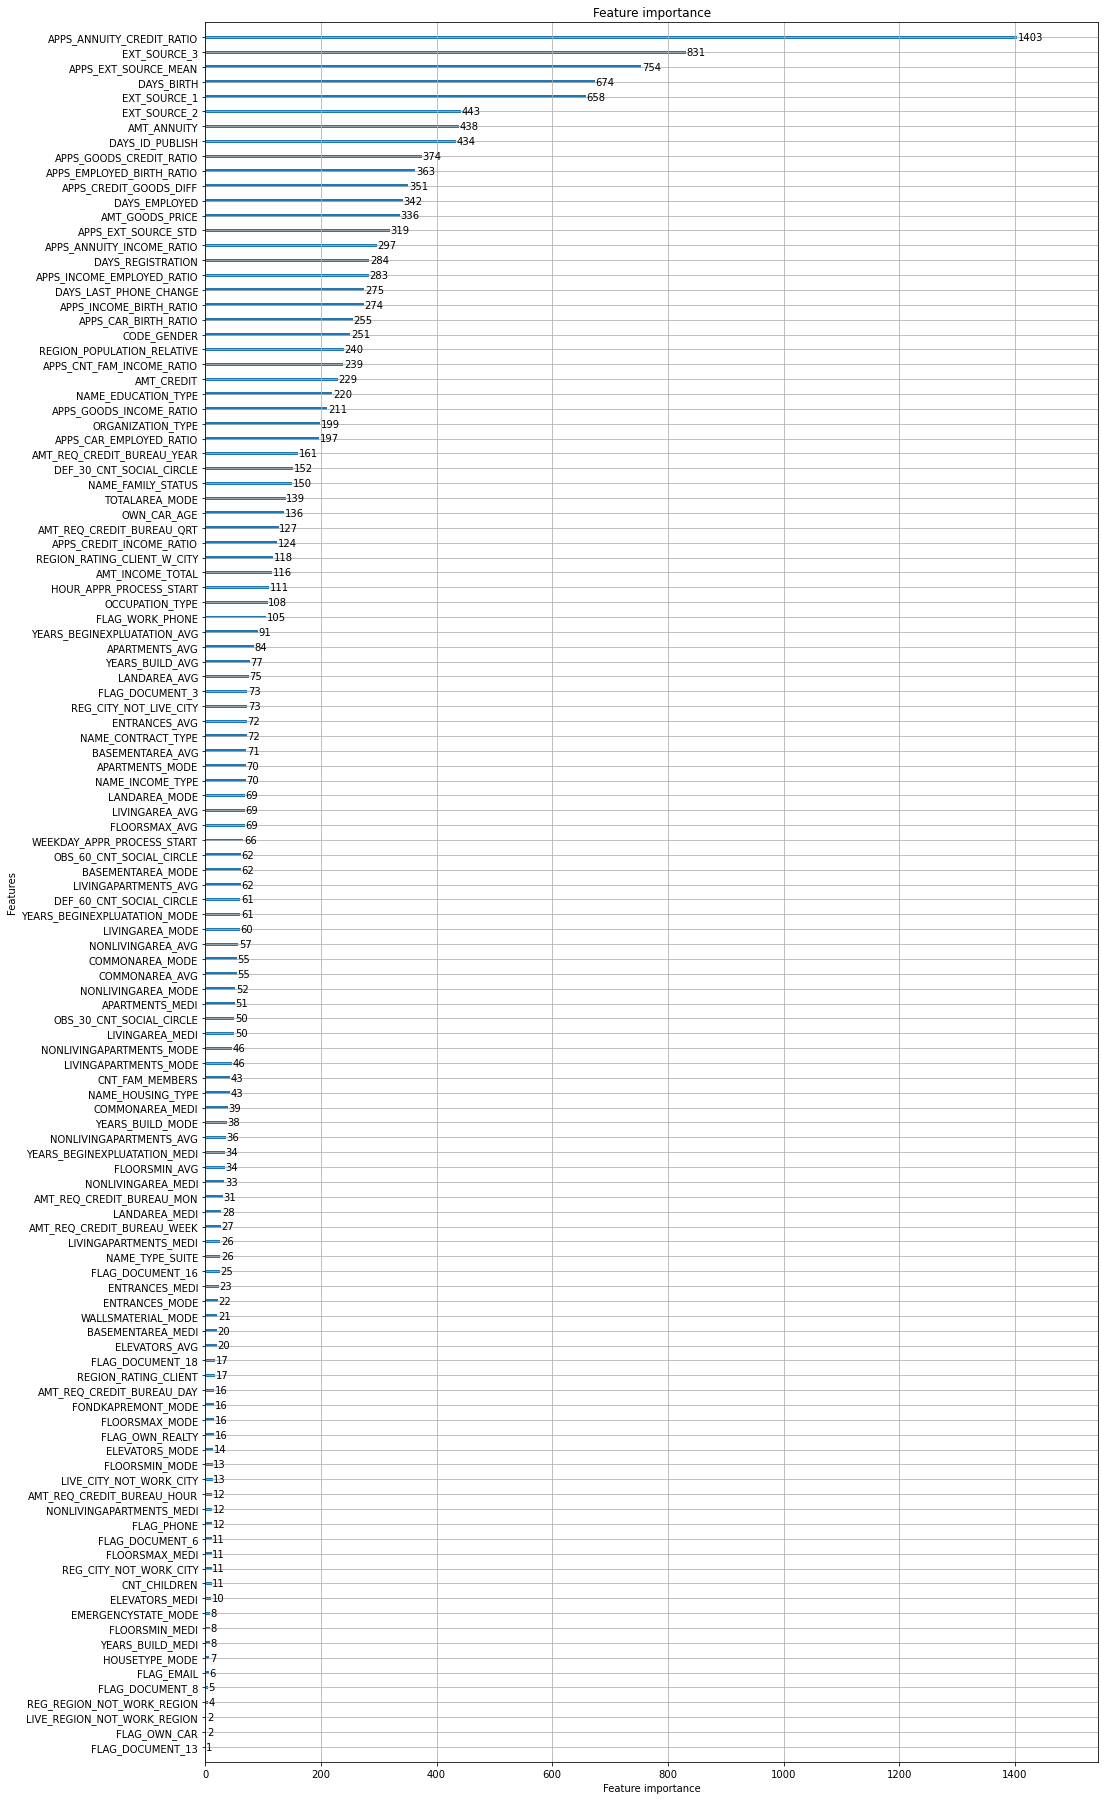

In [20]:
from lightgbm import plot_importance

plot_importance(rgb_clf, figsize=(16,32))

In [23]:
# Test데이터에 Predict하고 Kaggle에 제출
test_set = app_test.drop(['SK_ID_CURR'], axis=1)
preds = rgb_clf.predict_proba(test_set)[:,1]
app_test['TARGET'] = preds
submission = app_test[['SK_ID_CURR','TARGET']]
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.033097
1,100005,0.098638
2,100013,0.015205
3,100028,0.033079
4,100038,0.171087


In [24]:
submission.to_csv('/Users/younghun/Desktop/baseline02.csv',
                 index=False)